In [1]:
import json
import pandas as pd
from sqlalchemy import create_engine

**Data Preperation and Database setup**

In [4]:
import os
import json
import sqlite3
import pandas as pd

# ==========================================================
# CONFIG
# ==========================================================
DB_FILE = "/content/drive/MyDrive/YelpData/yelp_yelp.db"
JSON_FILES = {
    "business": "/content/drive/MyDrive/YelpData/yelp_academic_dataset_business.json",
    "review": "/content/drive/MyDrive/YelpData/yelp_academic_dataset_review.json",
    "user": "/content/drive/MyDrive/YelpData/yelp_academic_dataset_user.json",
    "tip": "/content/drive/MyDrive/YelpData/yelp_academic_dataset_tip.json",
    "checkin": "/content/drive/MyDrive/YelpData/yelp_academic_dataset_checkin.json"
}
CHUNKSIZE = 20000
# ==========================================================

# Ensure DB connection
conn = sqlite3.connect(DB_FILE)

def clean_dataframe(df):
    """Convert dicts/lists into JSON strings so SQLite accepts them."""
    for col in df.columns:
        df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else x)
    return df

def load_json_in_chunks(filepath, table_name, chunksize=20000):
    print(f"\n🚀 Starting load for {table_name} from {filepath} ...")
    with open(filepath, "r", encoding="utf-8") as f:
        batch = []
        count = 0
        for line in f:
            batch.append(json.loads(line))
            if len(batch) >= chunksize:
                df = pd.DataFrame(batch)
                df = clean_dataframe(df)
                df.to_sql(table_name, conn, if_exists="append", index=False)
                count += len(df)
                print(f"Inserted {count} rows into {table_name}...")
                batch = []
        if batch:
            df = pd.DataFrame(batch)
            df = clean_dataframe(df)
            df.to_sql(table_name, conn, if_exists="append", index=False)
            count += len(df)
            print(f"Inserted {count} rows into {table_name} ✅")

def load_and_insert_all():
    for table, path in JSON_FILES.items():
        load_json_in_chunks(path, table, CHUNKSIZE)

if __name__ == "__main__":
    load_and_insert_all()



🚀 Starting load for business from /content/drive/MyDrive/YelpData/yelp_academic_dataset_business.json ...
Inserted 20000 rows into business...
Inserted 40000 rows into business...
Inserted 60000 rows into business...
Inserted 80000 rows into business...
Inserted 100000 rows into business...
Inserted 120000 rows into business...
Inserted 140000 rows into business...
Inserted 150346 rows into business ✅

🚀 Starting load for review from /content/drive/MyDrive/YelpData/yelp_academic_dataset_review.json ...
Inserted 20000 rows into review...
Inserted 40000 rows into review...
Inserted 60000 rows into review...
Inserted 80000 rows into review...
Inserted 100000 rows into review...
Inserted 120000 rows into review...
Inserted 140000 rows into review...
Inserted 160000 rows into review...
Inserted 180000 rows into review...
Inserted 200000 rows into review...
Inserted 220000 rows into review...
Inserted 240000 rows into review...
Inserted 260000 rows into review...
Inserted 280000 rows into r

**Analysis**

In [65]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import sqlite3
import folium
from geopy.geocoders import Nominatim # for getting latitude and longitude
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
import warnings

In [7]:
# Connect to your database
conn = sqlite3.connect("/content/drive/MyDrive/YelpData/yelp_yelp.db")

# Show available tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

       name
0  business
1    review
2      user
3       tip
4   checkin


In [9]:
## Explore top 5 rows from each table
for table in tables['name']:   # <-- corrected column name
    print(f"\n Preview of table: {table}")
    display(pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5;", conn)) # as the tables are extremely big, we are not going to see entire table, rather top 5 we can just see


 Preview of table: business


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"{""ByAppointmentOnly"": ""True""}","Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"{""BusinessAcceptsCreditCards"": ""True""}","Shipping Centers, Local Services, Notaries, Ma...","{""Monday"": ""0:0-0:0"", ""Tuesday"": ""8:0-18:30"", ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{""BikeParking"": ""True"", ""BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{""Monday"": ""8:0-22:0"", ""Tuesday"": ""8:0-22:0"", ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{""RestaurantsDelivery"": ""False"", ""OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{""Monday"": ""7:0-20:0"", ""Tuesday"": ""7:0-20:0"", ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{""BusinessAcceptsCreditCards"": ""True"", ""Wheelc...","Brewpubs, Breweries, Food","{""Wednesday"": ""14:0-22:0"", ""Thursday"": ""16:0-2..."



 Preview of table: review


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15



 Preview of table: user


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0



 Preview of table: tip


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0



 Preview of table: checkin


,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


**Data Analysis**

We have a lot of businesses, but we need to find out restaurants business + that should be open ( we will filter it)

In [10]:
pd.read_sql_query("SELECT COUNT(*) FROM business",conn) # total unique businesses

,COUNT(*)
0,150346


In [12]:
# I only want restaurant business
pd.read_sql_query("""
    SELECT business_id
    FROM business
    WHERE lower(categories) LIKE '%restaurant%'
      AND is_open = 1
""", conn)


,business_id
0,MTSW4McQd7CbVtyjqoe9mw
1,CF33F8-E6oudUQ46HnavjQ
2,bBDDEgkFA1Otx9Lfe7BZUQ
3,eEOYSgkmpB90uNA7lDOMRA
4,il_Ro8jwPlHresjw9EGmBg
...,...
34999,w_4xUt-1AyY2ZwKtnjW0Xg
35000,l9eLGG9ZKpLJzboZq-9LRQ
35001,cM6V90ExQD6KMSU3rRB5ZA
35002,WnT9NIzQgLlILjPT0kEcsQ


my problem statement focuses on business goal --> review count and rating --> defines business goal

what is the descriptive stats for review count  and star rating for business?
avg ,min value, max value, median --> we'll get to know if outlier present in our data or not

In [23]:
# Get restaurant business IDs
business_id = pd.read_sql_query("""
    SELECT business_id, review_count
    FROM business
    WHERE lower(categories) LIKE '%restaurant%'
      AND is_open = 1
""", conn)

# If no businesses found, avoid SQL error
if business_id.empty:
    print("No matching businesses found")
else:
    # Convert to tuple for IN clause
    business_ids_tuple = tuple(business_id['business_id'])

    query = f"""
    SELECT
        AVG(review_count) AS avg_review_count,
        MIN(review_count) AS min_review_count,
        MAX(review_count) AS max_review_count,
        (
            SELECT review_count
            FROM business
            WHERE business_id IN {business_ids_tuple}
            ORDER BY review_count
            LIMIT 1
            OFFSET (SELECT COUNT(*)
                    FROM business
                    WHERE business_id IN {business_ids_tuple}) / 2
        ) AS median_review_count
    FROM business
    WHERE business_id IN {business_ids_tuple};
    """

    df = pd.read_sql_query(query, conn)
    print(df)


   avg_review_count  min_review_count  max_review_count  median_review_count
0        104.097789                 5              7568                   40


In [24]:
ids = tuple(business_id['business_id'].tolist())  # Convert to tuple for SQL

query = f"""
SELECT
    AVG(review_count) AS average_review_count,
    MIN(review_count) AS min_review_count,
    MAX(review_count) AS max_review_count,
    (SELECT review_count FROM business
     WHERE business_id IN {ids}
     ORDER BY review_count
     LIMIT 1 OFFSET (SELECT COUNT(*) FROM business WHERE business_id IN {ids}) / 2) AS median_review_count,

    AVG(stars) AS average_star_rating,
    MIN(stars) AS min_star_rating,
    MAX(stars) AS max_star_rating,
    (SELECT stars FROM business
     WHERE business_id IN {ids}
     ORDER BY stars
     LIMIT 1 OFFSET (SELECT COUNT(*) FROM business WHERE business_id IN {ids}) / 2) AS median_star_rating

FROM business
WHERE business_id IN {ids}
"""

df = pd.read_sql_query(query, conn)
df


,average_review_count,min_review_count,max_review_count,median_review_count,average_star_rating,min_star_rating,max_star_rating,median_star_rating
0,104.097789,5,7568,40,3.523969,1.0,5.0,3.5


In [25]:
df.transpose()

,0
average_review_count,104.097789
min_review_count,5.000000
max_review_count,7568.000000
median_review_count,40.000000
average_star_rating,3.523969
min_star_rating,1.000000
max_star_rating,5.000000
median_star_rating,3.500000


Outliers Present....we have to remove outliers using inter quartile range

In [29]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # This is the key line
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


In [30]:
business_id = remove_outliers(business_id, 'review_count')


In [31]:
business_id.shape

(31537, 2)

In [32]:
ids = tuple(business_id['business_id'].tolist())  # Convert to tuple for SQL

query = f"""
SELECT
    AVG(review_count) AS average_review_count,
    MIN(review_count) AS min_review_count,
    MAX(review_count) AS max_review_count,
    (SELECT review_count FROM business
     WHERE business_id IN {ids}
     ORDER BY review_count
     LIMIT 1 OFFSET (SELECT COUNT(*) FROM business WHERE business_id IN {ids}) / 2) AS median_review_count,

    AVG(stars) AS average_star_rating,
    MIN(stars) AS min_star_rating,
    MAX(stars) AS max_star_rating,
    (SELECT stars FROM business
     WHERE business_id IN {ids}
     ORDER BY stars
     LIMIT 1 OFFSET (SELECT COUNT(*) FROM business WHERE business_id IN {ids}) / 2) AS median_star_rating

FROM business
WHERE business_id IN {ids}
"""

df = pd.read_sql_query(query, conn)
df


,average_review_count,min_review_count,max_review_count,median_review_count,average_star_rating,min_star_rating,max_star_rating,median_star_rating
0,55.975426,5,248,33,3.477281,1.0,5.0,3.5


see here after removing outliers , values changes

now we will check which business has max reviews and which has max ratings... and is there any correlation between review and rating

order by review_count ---> compared wrt review_counts --> restaurants with highest review_counts

In [33]:
pd.read_sql_query(f"""select name , sum(review_count) as review_count , avg(stars) as avg_rating
from business
where business_id in {tuple(business_id['business_id'])}
group by name
order by review_count desc
limit 10 """,conn)

,name,review_count,avg_rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,Taco Bell,8017,2.141813
3,Chick-fil-A,7687,3.377419
4,First Watch,6761,3.875000
5,Panera Bread,6613,2.661905
6,Buffalo Wild Wings,6483,2.344828
7,Domino's Pizza,6091,2.290210
8,Wendy's,5930,2.030159
9,Chili's,5744,2.514706


order by avg_rating ---> compared wrt avg_rating --> restaurants with highest ratings

In [34]:
pd.read_sql_query(f"""select name , sum(review_count) as review_count , avg(stars) as avg_rating
from business
where business_id in {tuple(business_id['business_id'])}
group by name
order by avg_rating desc
limit 10 """,conn)

,name,review_count,avg_rating
0,ā café,48,5.0
1,two birds cafe,77,5.0
2,the brewers cabinet production,13,5.0
3,taqueria la cañada,17,5.0
4,la bamba,44,5.0
5,la 5th av tacos,24,5.0
6,el sabor mexican and chinese food,21,5.0
7,eat.drink.Om...YOGA CAFE,7,5.0
8,d4 Tabletop Gaming Cafe,8,5.0
9,cabbage vegetarian cafe,12,5.0


from both these we can see it's not necessary to have greater review counts to have higher ratings or business sucches..... but as a customer we prefer restaurants with both goood value....so we'll make a success score based on review count and ratings

In [ ]:
# do restaurants with higher engagement tend to have higher ratings?
# for every average rating what is their average review count ---> from here we can understand the trend with increase in engagement how rating changes
# as we are checking engagement we will also work with tip_count and checkin_count--> counting the number of dates by parsing the date
# in checkin_count each business_id has number of dates when customer came...so through that date column we have to parse
# 3 tables need to be joined ( business , tip, checkin)
# we will do aggregation on rating

In [37]:
import pandas as pd

query = """
SELECT
    business_id,
    SUM(LENGTH(date) - LENGTH(REPLACE(date, ',', '')) + 1) AS checkin_count
FROM checkin
GROUP BY business_id
"""

checkin_counts = pd.read_sql_query(query, conn)
checkin_counts


,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11
1,--0iUa4sNDFiZFrAdIWhZQ,10
2,--30_8IhuyMHbSOcNWd6DQ,2
3,--7PUidqRWpRSpXebiyxTg,10
4,--7jw19RH9JKXgFohspgQw,26
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67
131926,zznZqH9CiAznbkV6fXyHWA,1
131927,zzu6_r3DxBJuXcjnOYVdTw,23
131928,zzw66H6hVjXQEt0Js3Mo4A,2


In [39]:
pd.read_sql_query(""" select business_id , count(*) as tip_count
from tip
group by business_id
""",conn)

,business_id,tip_count
0,---kPU91CF4Lq2-WlRu9Lw,4
1,--0iUa4sNDFiZFrAdIWhZQ,6
2,--30_8IhuyMHbSOcNWd6DQ,1
3,--7PUidqRWpRSpXebiyxTg,3
4,--8IbOsAAxjKRoYsBFL-PA,4
...,...,...
106188,zzjCxn89a7RQo8keIOO_Ag,1
106189,zzjFdJwXuxBOGe9JeY_EMw,2
106190,zznJox6-nmXlGYNWgTDwQQ,6
106191,zzu6_r3DxBJuXcjnOYVdTw,2


In [42]:
ids = ','.join(f"'{i}'" for i in business_id['business_id'])

query = f"""
SELECT
    total.avg_rating AS rating,
    AVG(total.review_count) AS avg_review_count,
    AVG(total.checkin_count) AS avg_checkin_count,
    AVG(total.tip_count) AS avg_tip_count
FROM
    (SELECT
        b.business_id,
        SUM(b.review_count) AS review_count,
        AVG(b.stars) AS avg_rating,
        SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
        COALESCE(tip.tip_count, 0) AS tip_count
    FROM business b
    LEFT JOIN checkin cc
        ON b.business_id = cc.business_id
    LEFT JOIN (
        SELECT business_id, COUNT(*) AS tip_count
        FROM tip
        GROUP BY business_id
    ) AS tip
        ON b.business_id = tip.business_id
    WHERE b.business_id IN ({ids})
    GROUP BY b.business_id
    ) AS total
GROUP BY total.avg_rating
ORDER BY total.avg_rating
"""

review_count_df = pd.read_sql_query(query, conn)
review_count_df

,rating,avg_review_count,avg_checkin_count,avg_tip_count
0,1.0,14.365079,17.518072,1.751323
1,1.5,24.358459,34.480969,3.243719
2,2.0,27.759629,52.386515,3.815777
3,2.5,36.631037,79.349429,5.441404
4,3.0,48.054998,105.970405,7.384984
5,3.5,63.730125,125.781702,9.512747
6,4.0,73.136954,127.139075,10.328477
7,4.5,65.282554,86.177605,7.931141
8,5.0,31.127979,27.545113,2.912621


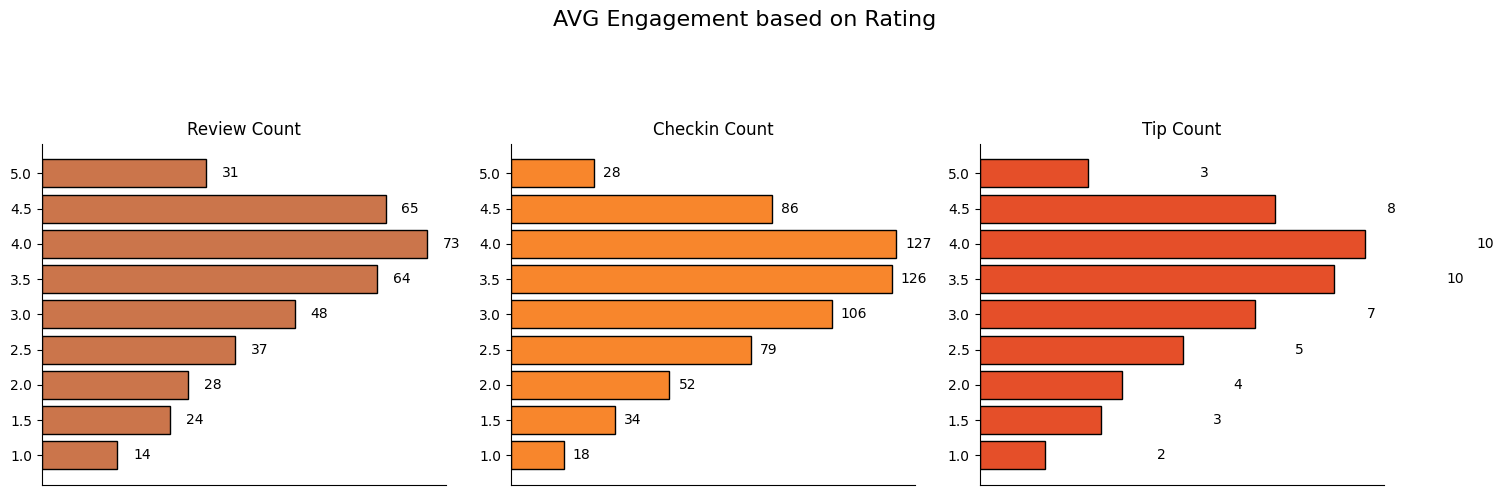

In [43]:
plt.figure(figsize=(15,5))
plt.suptitle('AVG Engagement based on Rating\n\n', fontsize=16)

# Review Count
plt.subplot(1,3,1)
plt.title('Review Count')
plt.barh(review_count_df['rating'].astype('str'),
         review_count_df['avg_review_count'],
         edgecolor='k', color='#CB754B')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
for i, value in enumerate(review_count_df['avg_review_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')

# Checkin Count
plt.subplot(1,3,2)
plt.title('Checkin Count')
plt.barh(review_count_df['rating'].astype('str'),
         review_count_df['avg_checkin_count'],
         edgecolor='k', color='#F8862C')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
for i, value in enumerate(review_count_df['avg_checkin_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')

# Tip Count
plt.subplot(1,3,3)
plt.title('Tip Count')
plt.barh(review_count_df['rating'].astype('str'),
         review_count_df['avg_tip_count'],
         edgecolor='k', color='#E54F29')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
for i, value in enumerate(review_count_df['avg_tip_count']):
    plt.text(value+3, i, str(round(value)), color='black', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


is there correlation between number of reviews , tips, check-ins for a business

In [46]:
ids = ','.join(f"'{i}'" for i in business_id['business_id'])

query = f"""
SELECT
    b.business_id,
    SUM(b.review_count) AS review_count,
    AVG(b.stars) AS avg_rating,
    SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
    COALESCE(tip.tip_count, 0) AS tip_count
FROM business b
LEFT JOIN checkin cc ON b.business_id = cc.business_id
LEFT JOIN (
    SELECT business_id, COUNT(*) AS tip_count
    FROM tip
    GROUP BY business_id
) AS tip ON b.business_id = tip.business_id
WHERE b.business_id IN ({ids})
GROUP BY b.business_id
"""

df = pd.read_sql_query(query, conn).dropna()
df

,business_id,review_count,avg_rating,checkin_count,tip_count
0,---kPU91CF4Lq2-WlRu9Lw,24,4.5,11.0,4
1,--0iUa4sNDFiZFrAdIWhZQ,14,3.0,10.0,6
2,--epgcb7xHGuJ-4PUeSLAw,34,3.0,118.0,6
3,--hF_3v1JmU9nlu4zfXJ8Q,15,4.5,7.0,0
4,--lqIzK-ZVTtgwiQM63XgQ,15,2.0,21.0,2
...,...,...,...,...,...
31532,zzbZtgPYZS8sTIWQH6DwEw,86,3.0,292.0,17
31533,zziDpuuJw-Km1J4BaGpBKA,6,3.5,20.0,2
31534,zzjFdJwXuxBOGe9JeY_EMw,47,4.0,27.0,2
31535,zznJox6-nmXlGYNWgTDwQQ,30,1.5,67.0,6


In [48]:
engagement_df = df[['review_count', 'checkin_count', 'tip_count']].corr()
print(engagement_df)

               review_count  checkin_count  tip_count
review_count       1.000000       0.644334   0.782699
checkin_count      0.644334       1.000000   0.781412
tip_count          0.782699       0.781412   1.000000


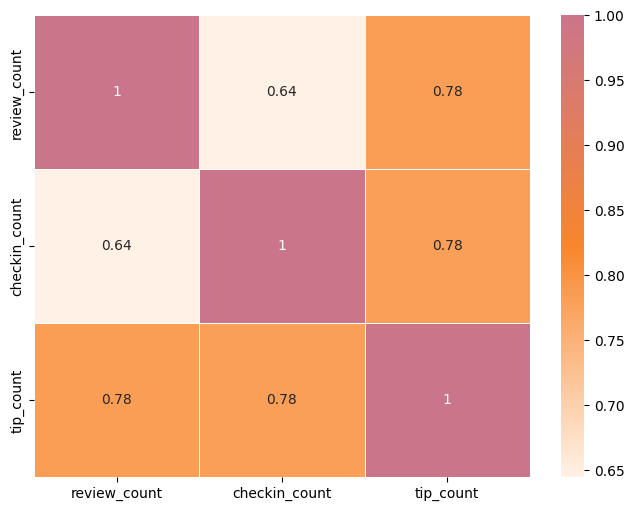

In [50]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#FFF1E5', '#F8862C', '#CB758B']
custom_cmap = LinearSegmentedColormap.from_list("mycmap", colors)

plt.figure(figsize=(8,6))
sns.heatmap(engagement_df, cmap=custom_cmap, annot=True, linewidths=0.5)
plt.show()


In [57]:
# do the user engagement of high rated and low rated restaurants differ?
#rating > 3.5 --> high rated ... ratinf < 3.5 --> low rated
ids = ','.join(f"'{i}'" for i in business_id['business_id'])

query = f"""
SELECT
    b.business_id,
    SUM(b.review_count) AS review_count,
    AVG(b.stars) AS avg_rating,
    SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
    COALESCE(tip.tip_count, 0) AS tip_count,
    CASE
        WHEN b.stars >= 3.5 THEN 'High-Rated'
        ELSE 'Low-Rated'
    END AS category
FROM business b
LEFT JOIN checkin cc ON b.business_id = cc.business_id
LEFT JOIN (
    SELECT business_id, COUNT(*) AS tip_count
    FROM tip
    GROUP BY business_id
) AS tip ON b.business_id = tip.business_id
WHERE b.business_id IN ({ids})
GROUP BY b.business_id, tip.tip_count
"""

engagement_df2 = pd.read_sql_query(query, conn).dropna()
engagement_df2


,business_id,review_count,avg_rating,checkin_count,tip_count,category
0,---kPU91CF4Lq2-WlRu9Lw,24,4.5,11.0,4,High-Rated
1,--0iUa4sNDFiZFrAdIWhZQ,14,3.0,10.0,6,Low-Rated
2,--epgcb7xHGuJ-4PUeSLAw,34,3.0,118.0,6,Low-Rated
3,--hF_3v1JmU9nlu4zfXJ8Q,15,4.5,7.0,0,High-Rated
4,--lqIzK-ZVTtgwiQM63XgQ,15,2.0,21.0,2,Low-Rated
...,...,...,...,...,...,...
31532,zzbZtgPYZS8sTIWQH6DwEw,86,3.0,292.0,17,Low-Rated
31533,zziDpuuJw-Km1J4BaGpBKA,6,3.5,20.0,2,High-Rated
31534,zzjFdJwXuxBOGe9JeY_EMw,47,4.0,27.0,2,High-Rated
31535,zznJox6-nmXlGYNWgTDwQQ,30,1.5,67.0,6,Low-Rated


In [58]:
engagement_df2.columns = engagement_df2.columns.str.strip()
engagement_df2.groupby('category')[['review_count', 'tip_count', 'checkin_count']].mean()


,review_count,tip_count,checkin_count
category,,,
High-Rated,66.532056,9.159340,111.07557
Low-Rated,38.270290,5.693289,79.00000


In [59]:
# we'll calculate success score based on review and rating matrix
def calculate_success_metric(df):
  success_score = []
  for index , row in df.iterrows():
    score = row['avg_rating'] *np.log(row['review_count']+1)
    success_score.append(score)
  return success_score


how do the success metric (review_count , rating) of restaurants vary accross different states and cities ?

In [71]:
city_df = pd.read_sql_query(f"""
SELECT
    city,
    state,
    latitude,
    longitude,
    AVG(stars) AS avg_rating,
    SUM(review_count) AS review_count,
    COUNT(*) AS restaurant_count
FROM business
WHERE business_id IN {tuple(business_id['business_id'])}
GROUP BY state, city, latitude, longitude
ORDER BY review_count DESC
LIMIT 100
""", conn)


In [62]:
city_df

,city,state,latitude,longitude,avg_rating,review_count,restaurant_count
0,Philadelphia,PA,39.953159,-75.159098,4.000000,541,6
1,Nashville,TN,36.163685,-86.782598,4.000000,517,3
2,Carmel,IN,39.978599,-86.128981,4.166667,503,3
3,Sparks,NV,39.541452,-119.716242,3.000000,452,4
4,Hendersonville,TN,36.302820,-86.619056,4.375000,431,4
5,Nashville,TN,36.170064,-86.665561,3.625000,424,4
6,Nashville,TN,36.138603,-86.800358,4.000000,417,2
7,Philadelphia,PA,39.958359,-75.195393,4.250000,416,6
8,Indianapolis,IN,39.858230,-85.978565,4.250000,411,2
9,Philadelphia,PA,39.949756,-75.148062,3.583333,379,12


In [72]:
city_df['success_score'] = calculate_success_metric(city_df)
city_df


,city,state,latitude,longitude,avg_rating,review_count,restaurant_count,success_score
0,Philadelphia,PA,39.953159,-75.159098,4.000000,541,6,25.181064
1,Nashville,TN,36.163685,-86.782598,4.000000,517,3,24.999901
2,Carmel,IN,39.978599,-86.128981,4.166667,503,3,25.927401
3,Sparks,NV,39.541452,-119.716242,3.000000,452,4,18.347676
4,Hendersonville,TN,36.302820,-86.619056,4.375000,431,4,26.549362
...,...,...,...,...,...,...,...,...
95,Palm harbor,FL,28.071784,-82.739812,4.500000,246,1,24.792248
96,Tampa,FL,27.965170,-82.550095,4.000000,246,1,22.037553
97,Boise,ID,43.588226,-116.281172,3.500000,246,1,19.282859
98,Avon,IN,39.763949,-86.354593,3.000000,246,1,16.528165


In [73]:
import folium
from branca.colormap import LinearColormap
from IPython.display import display  # Needed in Colab sometimes

# Create base map
m = folium.Map(location=[city_df['latitude'].mean(), city_df['longitude'].mean()], zoom_start=4)

# Define color scale
color_scale = LinearColormap(
    colors=['green', 'yellow', '#E54E29'],
    vmin=city_df['success_score'].min(),
    vmax=city_df['success_score'].max(),
    caption='Success Score'
)

# Add markers
for index, row in city_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_scale(row['success_score']),
        fill=True,
        fill_color=color_scale(row['success_score']),
        fill_opacity=0.7,
        popup=f"Success Score: {row['success_score']}"
    ).add_to(m)

# Add color scale legend
color_scale.add_to(m)

# Display map
display(m)  # Important in Colab


Are there any pattern in use engagement over time for successfull businesses compared to  less successful ones?
are there any seasonal trend in the user engagement for restaurants?

In [74]:
high_rated_engagement = pd.read_sql_query(f"""
SELECT review.month_year, review.review_count, tip.tip_count
FROM
    (SELECT strftime('%m-%Y', date) AS month_year, COUNT(*) AS review_count
     FROM review
     WHERE business_id IN {tuple(business_id['business_id'])} AND stars >= 3.5
     GROUP BY month_year) as review
JOIN
    (SELECT strftime('%m-%Y', tip.date) AS month_year, COUNT(*) AS tip_count
     FROM tip
     WHERE business_id IN {tuple(business_id['business_id'])}
     GROUP BY month_year) as tip
ON review.month_year = tip.month_year
ORDER BY review.month_year
""", conn)


In [76]:
high_rated_engagement

,month_year,review_count,tip_count
0,01-2010,1218,104
1,01-2011,2171,918
2,01-2012,3086,1859
3,01-2013,3801,1778
4,01-2014,4973,1964
...,...,...,...
149,12-2017,10161,1918
150,12-2018,12870,1501
151,12-2019,13756,1436
152,12-2020,11294,1085


In [75]:
low_rated_engagement = pd.read_sql_query(f"""
SELECT review.month_year, review.review_count, tip.tip_count
FROM
    (SELECT strftime('%m-%Y', date) AS month_year, COUNT(*) AS review_count
     FROM review
     WHERE business_id IN {tuple(business_id['business_id'])} AND stars < 3.5
     GROUP BY month_year) as review
JOIN
    (SELECT strftime('%m-%Y', tip.date) AS month_year, COUNT(*) AS tip_count
     FROM tip
     WHERE business_id IN {tuple(business_id['business_id'])}
     GROUP BY month_year) as tip
ON review.month_year = tip.month_year
ORDER BY review.month_year
""", conn)


In [77]:
low_rated_engagement

,month_year,review_count,tip_count
0,01-2010,613,104
1,01-2011,1103,918
2,01-2012,1748,1859
3,01-2013,2196,1778
4,01-2014,2769,1964
...,...,...,...
149,12-2017,5970,1918
150,12-2018,7574,1501
151,12-2019,7591,1436
152,12-2020,5014,1085


In [81]:
# every month what is avg rating of the business

# --- Overall Average Rating Over Time ---
time_rating = pd.read_sql_query(f"""
SELECT strftime('%m-%Y', date) AS month_year, AVG(stars) AS avg_rating
FROM review
WHERE business_id IN {tuple(business_id['business_id'])}
GROUP BY month_year
ORDER BY month_year
""", conn)

# --- Convert month_year to datetime for all DataFrames ---
for df in [high_rated_engagement, low_rated_engagement, time_rating]:
    df['month_year'] = pd.to_datetime(df['month_year'], format='%m-%Y')
    df.sort_values('month_year', inplace=True)
    df = df[df['month_year'] > '2017-12-31']  # Keep after 2017

# Optional: Assign back to variables
high_rated_engagement = high_rated_engagement[high_rated_engagement['month_year'] > '2017-12-31']
low_rated_engagement = low_rated_engagement[low_rated_engagement['month_year'] > '2017-12-31']
time_rating = time_rating[time_rating['month_year'] > '2017-12-31']

# --- Now all three DataFrames are ready ---
print("High-Rated Engagement:\n", high_rated_engagement.head())
print("Low-Rated Engagement:\n", low_rated_engagement.head())
print("Average Rating Over Time:\n", time_rating.head())



High-Rated Engagement:
    month_year  review_count  tip_count
8  2018-01-01         12091       1784
21 2018-02-01         11652       1794
33 2018-03-01         13731       2103
46 2018-04-01         13220       1995
59 2018-05-01         13232       1949
Low-Rated Engagement:
    month_year  review_count  tip_count
8  2018-01-01          6328       1784
21 2018-02-01          6480       1794
33 2018-03-01          7459       2103
46 2018-04-01          7088       1995
59 2018-05-01          7292       1949
Average Rating Over Time:
    month_year  avg_rating
12 2018-01-01    3.706716
29 2018-02-01    3.651335
46 2018-03-01    3.676404
63 2018-04-01    3.694554
80 2018-05-01    3.669119


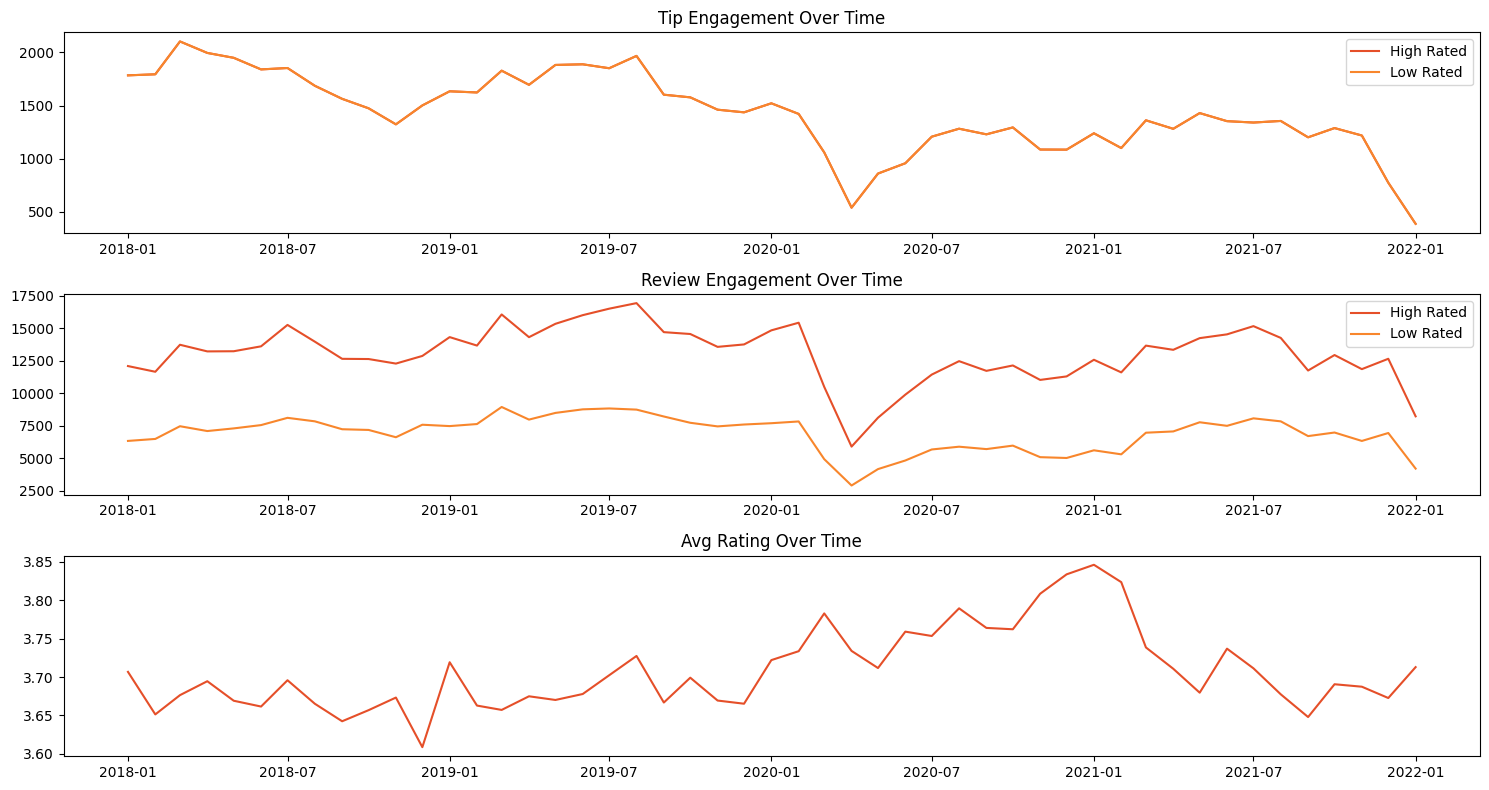

In [82]:
time_rating['month_year'] = pd.to_datetime(time_rating['month_year'])
time_rating.sort_values('month_year', inplace=True)
time_rating = time_rating[time_rating['month_year'] > '2017']

high_rated_engagement['month_year'] = pd.to_datetime(high_rated_engagement['month_year'])
high_rated_engagement.sort_values('month_year', inplace=True)
high_rated_engagement = high_rated_engagement[high_rated_engagement['month_year'] > '2017']

low_rated_engagement['month_year'] = pd.to_datetime(low_rated_engagement['month_year'])
low_rated_engagement.sort_values('month_year', inplace=True)
low_rated_engagement = low_rated_engagement[low_rated_engagement['month_year'] > '2017']

high_rated_engagement['avg_rating'] = time_rating['avg_rating'].values


plt.figure(figsize=(15,8))

plt.subplot(3,1,1)
plt.title('Tip Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['tip_count'], label='High Rated', color='#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['tip_count'], label='Low Rated', color='#F8862C')
plt.legend()

plt.subplot(3,1,2)
plt.title('Review Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['review_count'], label='High Rated', color='#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['review_count'], label='Low Rated', color='#F8862C')
plt.legend()

plt.subplot(3,1,3)
plt.title('Avg Rating Over Time')
plt.plot(time_rating['month_year'], time_rating['avg_rating'], color='#E54F29')
plt.tight_layout()
plt.show()


In [83]:
tip_high_rated = high_rated_engagement[['month_year','tip_count']].set_index('month_year')
review_high_rated = high_rated_engagement[['month_year','review_count']].set_index('month_year')
rating_df = time_rating[['month_year','avg_rating']].set_index('month_year')


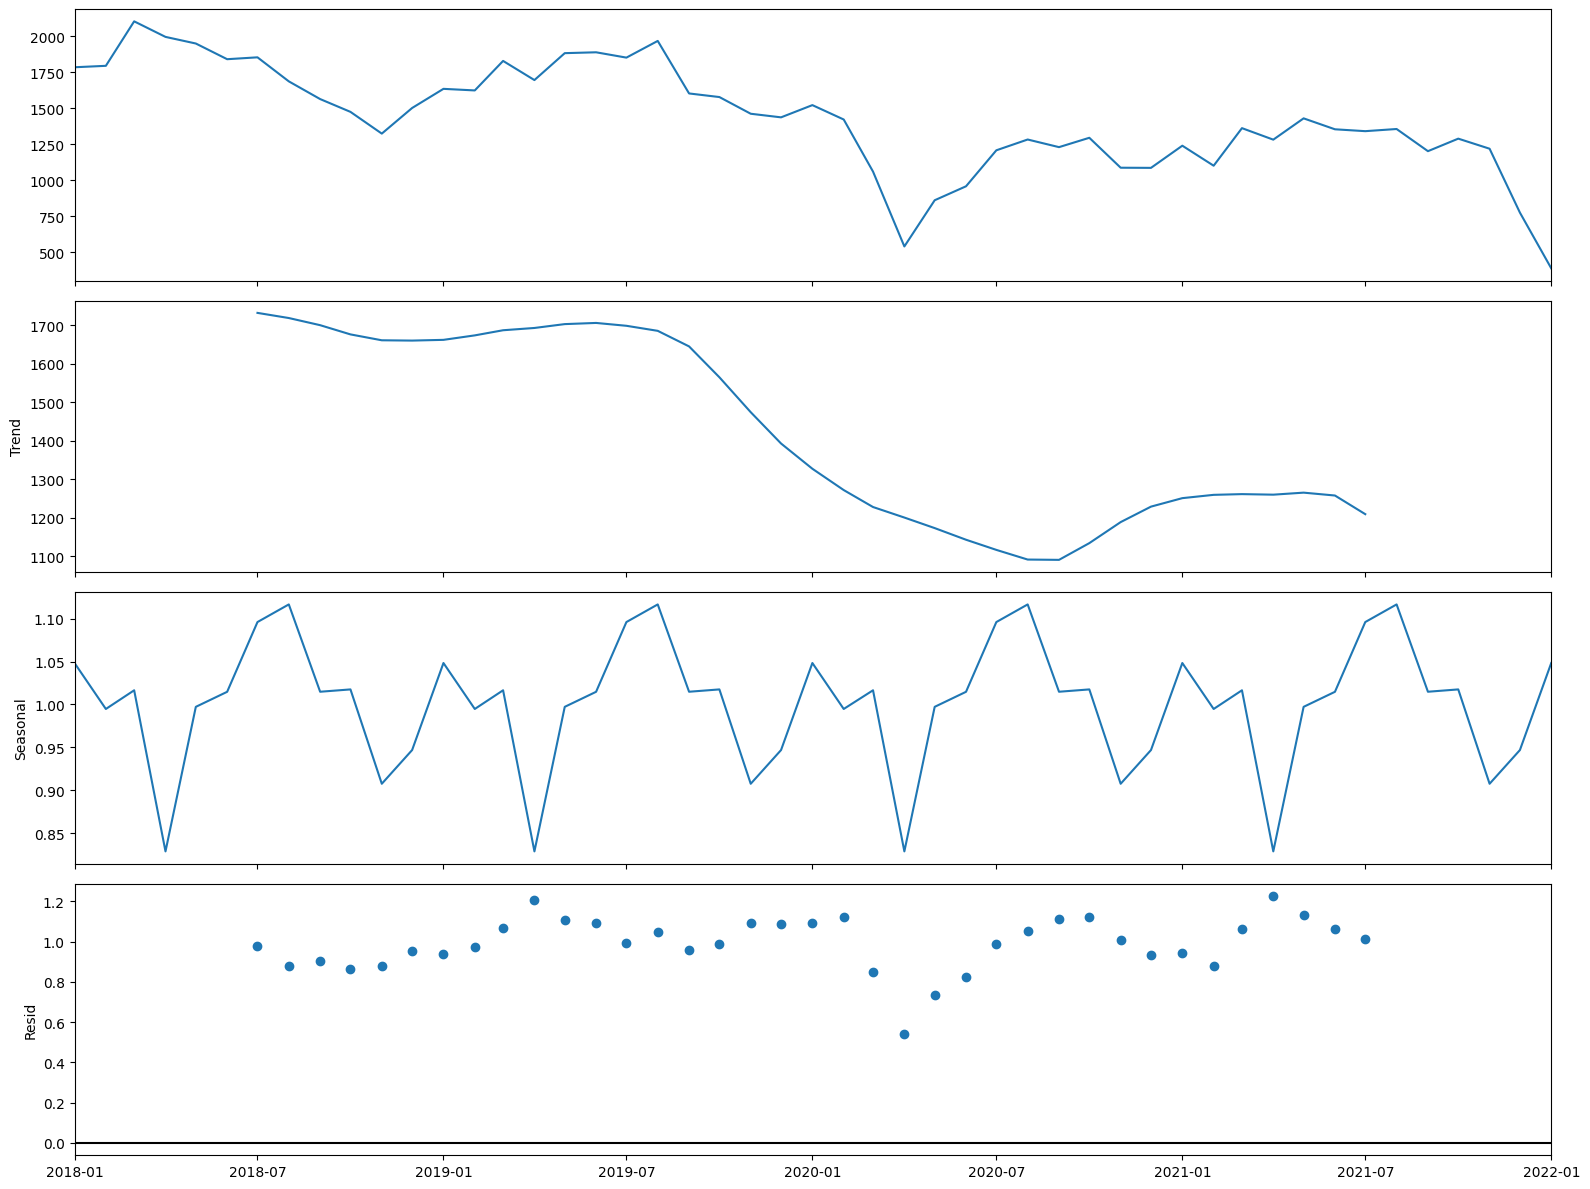

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

multiplicative_decomposition = seasonal_decompose(
    tip_high_rated,
    model='multiplicative',
    period=12
)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot()
plt.show()


**Sentiment Analysis**

**how does the sentiment of reviews and tips (useful, cool , funny) correlate with the success metrics of restaurants**

In [87]:
sentiment_df = pd.read_sql_query(f"""
SELECT
    b.business_id,
    AVG(b.stars) AS avg_rating,
    SUM(b.review_count) AS review_count,
    s.useful_count,
    s.funny_count,
    s.cool_count
FROM
    (SELECT business_id,
            SUM(useful) AS useful_count,
            SUM(funny) AS funny_count,
            SUM(cool) AS cool_count
     FROM review
     GROUP BY business_id) AS s
JOIN business AS b ON b.business_id = s.business_id
WHERE b.business_id IN {tuple(business_id['business_id'])}
GROUP BY b.business_id
ORDER BY review_count DESC
""", conn)


In [88]:
sentiment_df = remove_outliers(sentiment_df, 'review_count')
sentiment_df = remove_outliers(sentiment_df, 'useful_count')
sentiment_df = remove_outliers(sentiment_df, 'funny_count')
sentiment_df = remove_outliers(sentiment_df, 'cool_count')

In [89]:
sentiment_df['success_score'] = calculate_success_metric(sentiment_df)

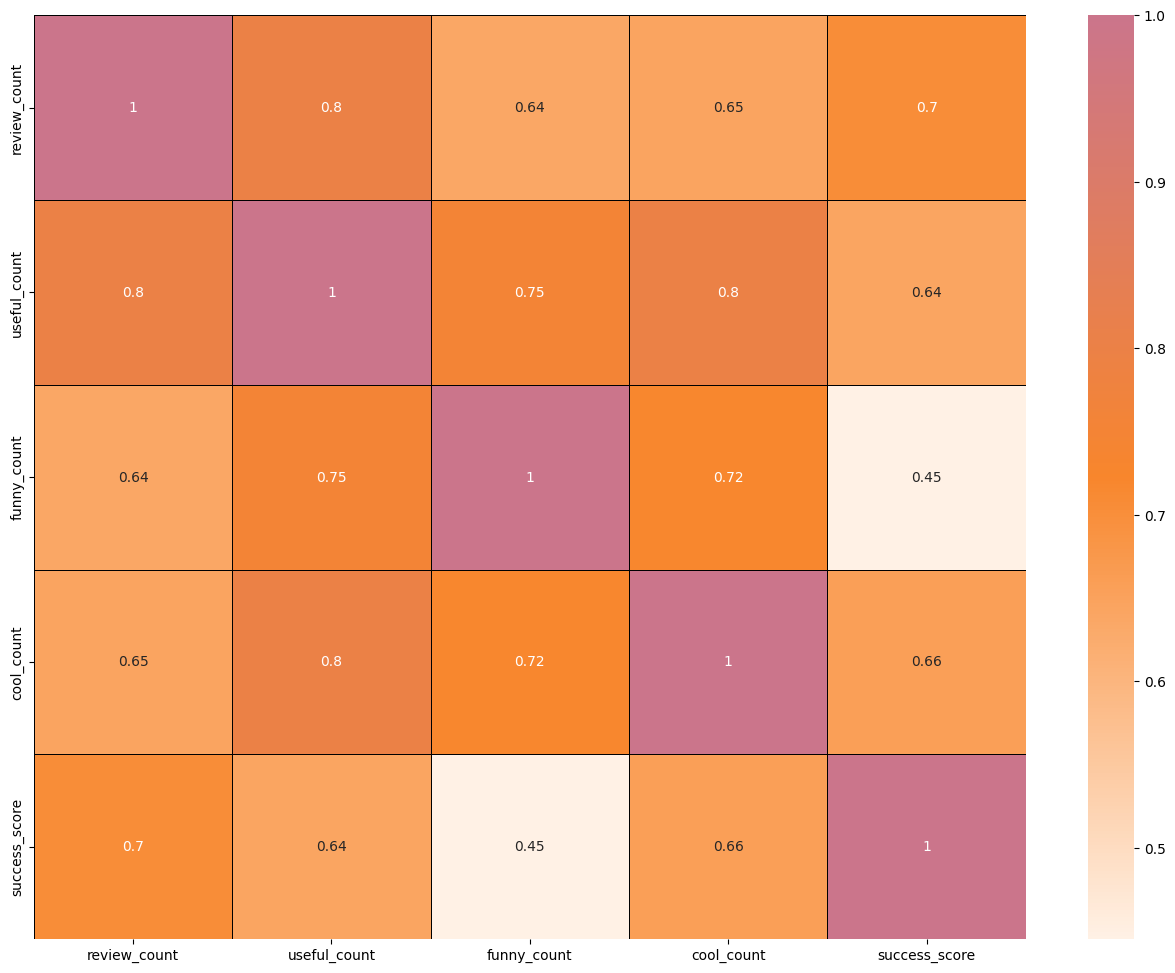

In [90]:
sns.heatmap(sentiment_df.iloc[:,2:].corr(), cmap = custom_cmap, annot= True , linewidths= 0.5, linecolor='black')
plt.show()

In [91]:
elite_df = pd.read_sql_query("""
SELECT
    elite_status,
    COUNT(*) AS user_count,
    SUM(review_count) AS total_review_count
FROM
    (SELECT
        CASE
            WHEN elite IS NULL OR elite = '' THEN 'Not Elite'
            ELSE 'Elite'
        END AS elite_status,
        review_count
     FROM user
    ) AS user_elite
GROUP BY elite_status;
""", conn)

elite_df


,elite_status,user_count,total_review_count
0,Elite,91198,20484441
1,Not Elite,1896699,26021235


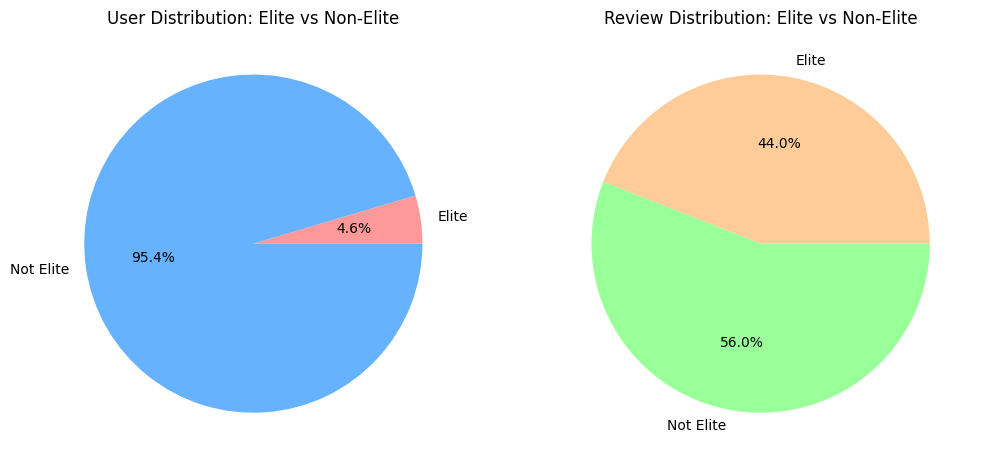

In [92]:
import matplotlib.pyplot as plt

# Set up subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart 1: User distribution
axes[0].pie(elite_df['user_count'],
            labels=elite_df['elite_status'],
            autopct='%1.1f%%',
            colors=['#FF9999','#66B2FF'])
axes[0].set_title('User Distribution: Elite vs Non-Elite')

# Pie chart 2: Review distribution
axes[1].pie(elite_df['total_review_count'],
            labels=elite_df['elite_status'],
            autopct='%1.1f%%',
            colors=['#FFCC99','#99FF99'])
axes[1].set_title('Review Distribution: Elite vs Non-Elite')

plt.show()
